In [1]:
%pylab inline

import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score

import datetime, time

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read data
wnv_train = pd.read_csv('../working/train_f.csv', index_col=0)
wnv_test = pd.read_csv('../working/test_fn.csv', index_col=0)
#f_names = wnv_train.columns[2:]

In [3]:
# convert list of labels to binary class matrix
labels = wnv_train.WnvPresent.values.astype('int')
yr_train = labels
wnv_train.drop('WnvPresent', axis=1, inplace=True)
f_names = wnv_train.columns

In [4]:
# raw data
#yr_train = wnv_train[:,1].astype(int)
Xr_train =(wnv_train.values).astype('float64')
Xr_test = (wnv_test.values).astype('float64')

# normalize data
scaler = StandardScaler()
scaler.fit(Xr_train)
Xn_train = scaler.transform(Xr_train)
Xn_test = scaler.transform(Xr_test)

X_train, X_test, y_train, y_test = train_test_split(Xn_train, yr_train)

In [5]:
# parameters
n_neighbors = 30
n_components = 65
n_estimators = 5000
n_jobs = 3
p_level = 0.3

In [6]:
#clf = KNeighborsClassifier(n_neighbors=n_neighbors)
clf = ExtraTreesClassifier(n_estimators=n_estimators, n_jobs=n_jobs)
#clf.fit(X_train, y_train)
clf.fit(Xn_train, yr_train)

# use the model to predict the labels of the test data
predicted = clf.predict(X_test)
proba = clf.predict_proba(X_test)
expected = y_test

In [7]:
# accuracy
matches = (predicted == expected)
print matches.sum() / float(len(matches))

# f1 score

print classification_report(expected, predicted)

# confusion matrix
print confusion_matrix(expected, predicted)

# auc
print roc_auc_score(expected, proba[:,1])

0.99238675295
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      2467
          1       0.99      0.88      0.93       160

avg / total       0.99      0.99      0.99      2627

[[2466    1]
 [  19  141]]
0.998702877989


Area under the ROC curve : 0.998703


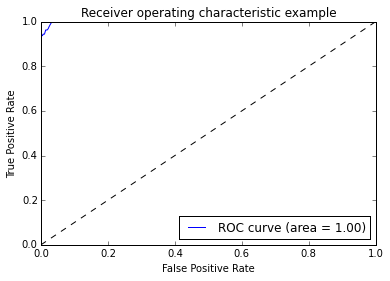

In [8]:
#print np.count_nonzero(predicted == 1)
#print np.count_nonzero(y_test)
#np.max(proba[:,1])
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(expected, proba[:,1])
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve : %f" % roc_auc

# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [9]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(f_names)):
#for f in range(15):
    print("%d. %s (%f)" % (f + 1, f_names[indices[f]], importances[indices[f]]))

Feature ranking:
1. NumMosquitos (0.347409)
2. Longitude (0.258532)
3. Latitude (0.246597)
4. CULEX PIPIENS/RESTUANS (0.015546)
5. CULEX PIPIENS (0.015461)
6. CULEX RESTUANS (0.008817)
7. StnPressure_1_d19 (0.001421)
8. DayOfYear (0.001276)
9. CULEX TERRITANS (0.001262)
10. WetBulb_2_d17 (0.001058)
11. WetBulb_1_d18 (0.001038)
12. WetBulb_1_d19 (0.000953)
13. DewPoint_1_d1 (0.000695)
14. StnPressure_2_d19 (0.000651)
15. Cool_2_d20 (0.000647)
16. Cool_1_d20 (0.000646)
17. DewPoint_2_d1 (0.000633)
18. Cool_1_d19 (0.000613)
19. WetBulb_1_d1 (0.000587)
20. Cool_2_d19 (0.000578)
21. DewPoint_1_d10 (0.000577)
22. StnPressure_2_d12 (0.000529)
23. StnPressure_2_d4 (0.000517)
24. Cool_1_d12 (0.000511)
25. Tmin_2_d12 (0.000486)
26. WetBulb_1_d12 (0.000481)
27. Cool_2_d12 (0.000479)
28. Tavg_1_d20 (0.000473)
29. WetBulb_2_d1 (0.000468)
30. PrecipTotal_2_d7 (0.000465)
31. WetBulb_1_d20 (0.000451)
32. PrecipTotal_2_d3 (0.000449)
33. Tavg_2_d20 (0.000448)
34. DewPoint_1_d8 (0.000445)
35. SeaLevel_2_

In [10]:
proba = clf.predict_proba(Xn_test)
print np.max(proba[:,1])

0.312878472222


In [11]:
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')

def write_preds(proba, fname):
    pd.DataFrame({"Id": list(range(1,len(proba)+1)), "WnvPresent": proba}).to_csv(fname, index=False, header=True)

write_preds(proba[:,1], "../working/sklearn_test_" + st + ".csv")